https://app.dataquest.io/c/25/m/217/guided-project%3A-analyzing-nyc-high-school-data/1/introduction?path=16&slug=data-cleaning-python-skill

## Read in the data

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("C:/Users/david/Downloads/schools/{0}".format(f), encoding='utf8')
    data[f.replace(".csv", "")] = d

## Read in the surveys

In [2]:
all_survey = pd.read_csv("C:/Users/david/Downloads/schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("C:/Users/david/Downloads/schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

C:\Users\david\AppData\Local\Temp\ipykernel_15608\3276045029.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  survey["DBN"] = survey["dbn"]


## Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

## Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

## Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(np.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

## Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

## Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

C:\Users\david\AppData\Local\Temp\ipykernel_15608\3398560250.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  combined = combined.fillna(combined.mean())


## Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

## Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


## Plotting survey correlations

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

## Find correlations for `sat_score`

<AxesSubplot:>

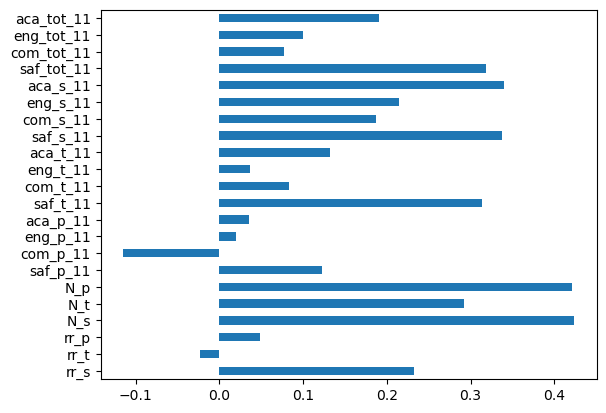

In [11]:
%matplotlib inline

combined.corr()['sat_score'][survey_fields].plot.barh()

- `N_s`: Number of student respondents
- `N_t`: Number of teacher respondents
- `N_p`: Number of parent respondents

There is a high correlation between `N_s`, `N_t`, `N_p` and `sat_score`. Meaning the more teachers and students equates to higher overall value in `sat_score`.

- `saf_t_11`: Safety and Respect score based on teacher responses
- `saf_s_11`: Safety and Respect score based on studeny responses

Additionally we can see a correlation between `saf_t_11` and `saf_s_11`, which indicates how safe students and teachers feel, and `sat_score`. Which makes sense because no one can really focus on higher education if an unsafe environment.

More interestingly, `rr_s` (student response rate) correlates with `sat_score`. Which could make sense because students who fill out surveys are more likely to achieve higher academic standards.

- `aca_s_11`: Academic expectations score based on student responses
- `aca_t_11`: Academic expectations score based on teacher responses
- `aca_p_11`: Academic expectations score based on parent responses

The last interesting correlations are `aca_s_11`, `aca_t_11`, and `aca_p_11`. Where students expectations for high acadmeic standards strongly correlates with `sat_score`. Where as parent and teacher (`aca_p_11`, `aca_t_11`) expectations for high academic standards does not correlate with `sat_score`.

## Investigating Safety Scores

Text(0, 0.5, 'SAT Scores')

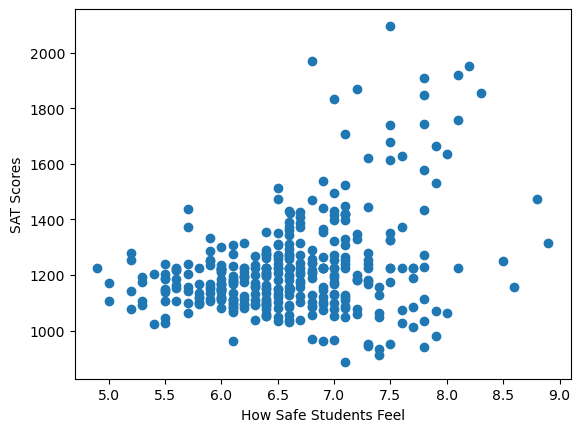

In [12]:
plt.scatter(combined['saf_s_11'],combined['sat_score'])
plt.xlabel('How Safe Students Feel')
plt.ylabel('SAT Scores')

The graph above would indicate that there is some correlation between how safe students feel and how high they score on the SAT. Let's look at the average safety score for each borough to gain some more insight on this.

In [13]:
borough = combined.groupby(['boro'])['saf_s_11'].agg(np.mean)
borough.sort_values(ascending=False)

boro
Manhattan        6.831370
Queens           6.721875
Bronx            6.606577
Staten Island    6.530000
Brooklyn         6.370755
Name: saf_s_11, dtype: float64

It seems that Manhattan and Queens have the higher safety scores, whereas Brooklyns is quite low.

## Exploring Racial Factors for `sat_score`

Each school has the following columns that indicate percentage of race present:

- `white_per`
- `asian_per`
- `black_per`
- `hispanic_per`

<AxesSubplot:>

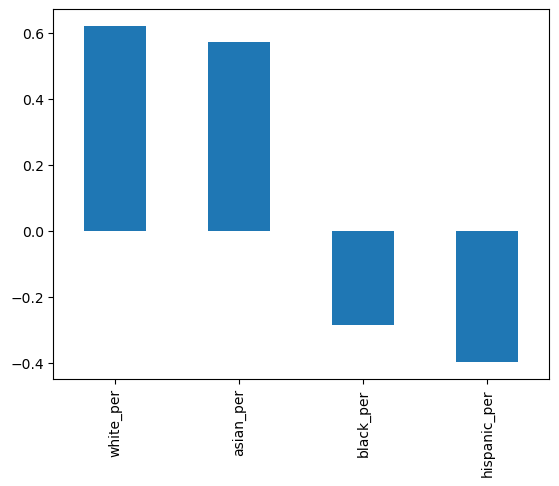

In [28]:
race_fields = ["white_per", "asian_per", "black_per", "hispanic_per"]
combined.corr()['sat_score'][race_fields].plot.bar()

As shown above white and asian students have a high positive correlation with SAT scores, whereas black and hispanic student have a noticeable negative correlation with SAT scores. This could be due to black and hispanic students who reside in lower income areas and thus schools have less to spend to better their institutes.

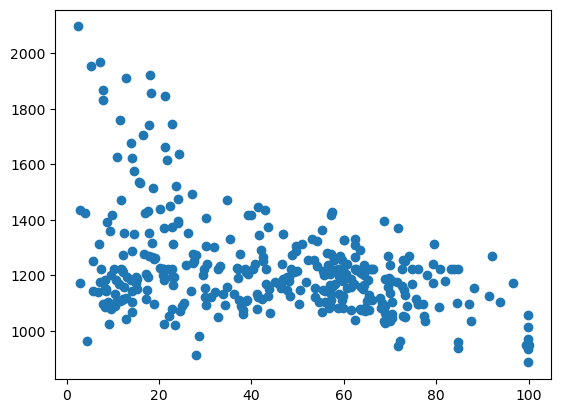

In [30]:
plt.scatter(combined['hispanic_per'], combined['sat_score'])

In [32]:
# Schools with 95%+ hispanic population

print(combined[combined['hispanic_per'] > 95]['SCHOOL NAME'])

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


In [33]:
combined.columns

Index(['DBN', 'SCHOOL NAME', 'Num of SAT Test Takers',
       'SAT Critical Reading Avg. Score', 'SAT Math Avg. Score',
       'SAT Writing Avg. Score', 'sat_score', 'SchoolName', 'AP Test Takers ',
       'Total Exams Taken',
       ...
       'priority05', 'priority06', 'priority07', 'priority08', 'priority09',
       'priority10', 'Location 1', 'lat', 'lon', 'school_dist'],
      dtype='object', length=160)

A quick google search yields ample information that these schools cater towards new immigrants, therefore it would be safe to assume that many of these students do not know very well, and will not score well on `SAT Critical Reading Avg. Score` and `SAT Writing Avg. Score` which make up `sat_score`.

In [55]:
# Find schools with a small hispanic percentage and high SAT scores

print(combined[(combined['hispanic_per'] < 10) & (combined['sat_score'] > 1800)]['SCHOOL NAME'])

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


Wikipedia shows that most of these  schools are known as [specialized high schools](https://en.wikipedia.org/wiki/Specialized_high_schools_in_New_York_City), virtually only accessible to the most gifted of students. Moreover, these schools rank top in the country. This doesn't reveal and connections with `hispanic_per` but it does make sense why these schools have such high SAT scores.

## Exploring Gender Factors for `sat_score`

Let's change gears and look at how males do on the SAT vs. females. In our dataframe we have `male_per` and `female_per` which indicates the percentage of each respective column.

Text(0.5, 1.0, 'SAT Preformance Based on Gender')

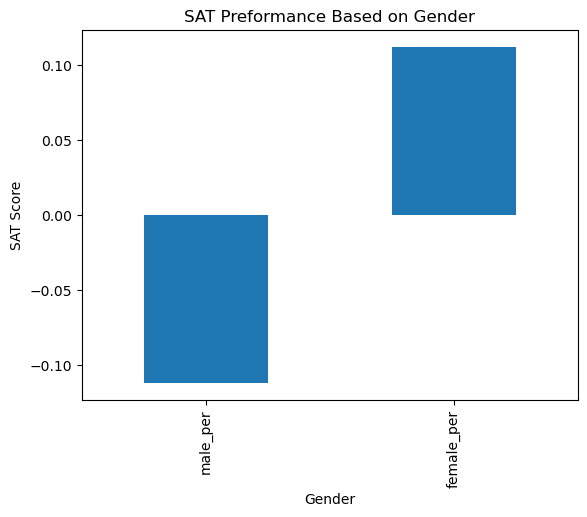

In [61]:
combined.corr()['sat_score'][['male_per','female_per']].plot.bar()
plt.xlabel('Gender')
plt.ylabel('SAT Score')
plt.title('SAT Preformance Based on Gender')

There seems to be a positive correlation for females and SAT scores, and inversely a negative correlation between males and SAT scores. However, both correlations are very weak with values at -0.1 and .1.

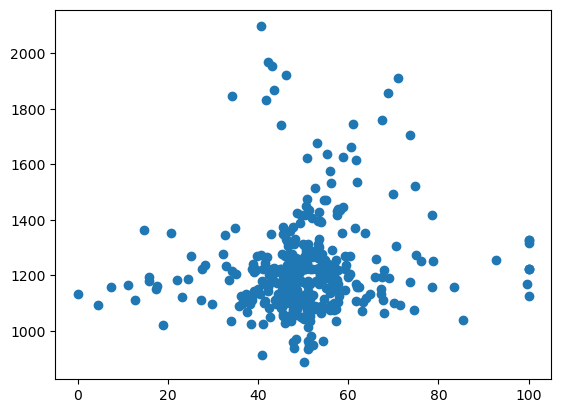

In [62]:
plt.scatter(combined['female_per'], combined['sat_score'])

Using a scatter plot to look at the percentage of `females_per` vs `sat_score` does not indicate any clear correlation. Let's see if we can find schools that specifically have a high `female_per` and `sat_score`.

In [63]:
combined[(combined['female_per'] > 60) & (combined['sat_score'] > 1700)]['SCHOOL NAME']

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

A quick search of these schools show that they are all very selective schools that specialize in liberal arts and have high academic standards.

## Looking for Correlation Between `AP_Test Takers` and `sat_score`

Let's move away from looking at correlations with `sat_score` as that column is also highly correlated with `total_enrollment`. Let's find the percentage of students in each school that took an AP exam and assign it to a new column called `ap_per`.

In [65]:
combined['ap_per'] = combined['AP Test Takers ']/combined['total_enrollment']
combined['ap_per']

0      0.305756
1      0.098985
2      0.031773
3      0.351577
4      0.158091
         ...   
358    0.077558
359    0.297301
360    0.190955
361    0.026616
362    0.073593
Name: ap_per, Length: 363, dtype: float64

Text(0, 0.5, 'SAT Score')

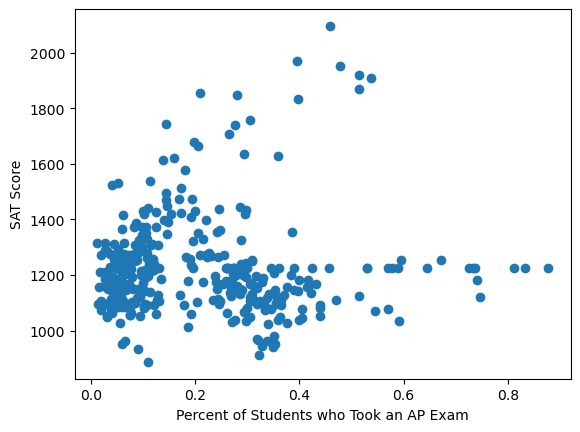

In [68]:
plt.scatter(combined['ap_per'], combined['sat_score'])
plt.xlabel('Percent of Students who Took an AP Exam')
plt.ylabel('SAT Score')

It seems like there may be a slight correlation between students who took AP exams and their SAT scores.

TODO:

 - Determe whether there's a correlation between class size and SAT scores
 - Figure out which neighborhoods have the best schools
 - If we combine this information with a dataset containing property values, we could find the least expensive neighborhoods that have good schools.
 - Investigate the differences between parent, teacher, and student responses to surveys.
 - Assign scores to schools based on sat_score and other attributes.